In [1]:
from tools import adap_whitening_2, load, estimate_derivative
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
from pathlib import Path
from cycler import cycler

In [5]:
file = '1_600_20'
i0, i1 = 290, 500

data, sequence, times_sec, sequence_sec = load(file, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=data)
data = np.hstack((data, d_sensor_data))


/var/folders/w2/znr__42x45s1rjb1hj583bbr0000gn/T/ipykernel_4415/1067190142.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  runs.append((int(idx_start), int(idx_end), int(sequence[j][1])))
/var/folders/w2/znr__42x45s1rjb1hj583bbr0000gn/T/ipykernel_4415/1067190142.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = out


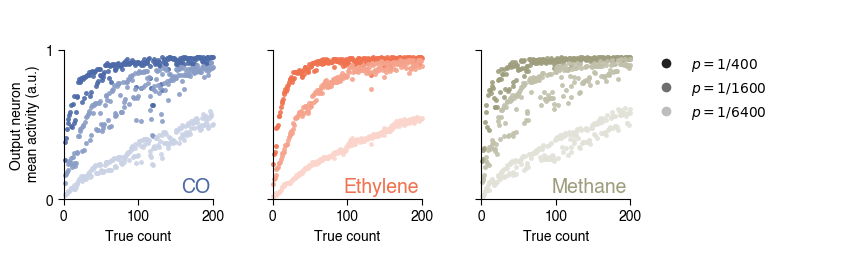

In [7]:
n_out = 1
n_hd = 10000
k = 200
p = 1./5.  # flip probability
c1 = 'white'
p_list = [1/400., 1/1600., 1/6400.]

rng = np.random.default_rng(42)
cm = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, gridspec_kw={"wspace": 0.4})
axes = axes.flatten()

x_dense = data
n_dense = x_dense.shape[1]

colour = np.zeros_like(times_sec, dtype=int)
runs = []
for j in range(len(sequence_sec)):
    t0 = sequence_sec[j]
    t1 = sequence_sec[j+1] if j+1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t0) & (times_sec < t1)
    colour[mask] = int(sequence[j][1])
    idx_start = np.where((times_sec >= t0) & (np.roll(times_sec, 1) <= t0) == True)[0]
    idx_end = np.where((np.roll(times_sec, -1) > t1) & (times_sec <= t1) == True)[0]
    if idx_end.size == 0:
        idx_end = len(times_sec)
    runs.append((int(idx_start), int(idx_end), int(sequence[j][1])))

for idx_p, p in enumerate(p_list):
    W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))
    x_hd = x_dense @ W_hd.T
    ranks = np.argsort(np.argsort(-x_hd, axis=1), axis=1)
    z_hd = np.where(ranks < k, 1., 0.)
    W_out = np.zeros((n_out, n_hd))
    output = np.zeros((x_dense.shape[0]))

    for i, row in enumerate(z_hd):
        active_idx = np.flatnonzero(row)                          # indices where z_hd==1
        to_flip = active_idx[rng.random(active_idx.size) < p]     # Bernoulli(p) per active index
        W_out[0, to_flip] = 1.0

        out = row @ W_out.T
        output[i] = out

    # Count how many presentations (blocks) each gas has in the whole recording
    gas_presentations = {}

    # Initialize dict-of-lists to collect per-block stats
    block_sums = {
        "gas_id": [],
        "start_idx": [],
        "end_idx": [],          # end is exclusive
        "length": [],           # <-- NEW: block length (samples)
        "start_time": [],
        "end_time": [],
        "output_sum": [],
        "true_count": [],       # total presentations of that gas in the recording
    }

    # Fill the dict
    for s, e, gas_id in runs:
        if gas_id == 0:
            continue
        gas_presentations[gas_id] = gas_presentations.get(gas_id, 0) + 1
        block_sums["gas_id"].append(int(gas_id))
        block_sums["start_idx"].append(int(s))
        block_sums["end_idx"].append(int(e))
        block_sums["length"].append(int(e - s))
        block_sums["start_time"].append(float(times_sec[s]))
        block_sums["end_time"].append(float(times_sec[e-1] if e-1 < len(times_sec) else times_sec[-1]))
        block_sums["output_sum"].append(float(output[s:e].sum()))
        block_sums["true_count"].append(int(gas_presentations[gas_id]))

    # Extract arrays
    gid = np.asarray(block_sums["gas_id"])
    tc  = np.asarray(block_sums["true_count"])
    os_ = np.asarray(block_sums["output_sum"], dtype=float)
    L   = np.asarray(block_sums["length"], dtype=float)

    # Mean output per block = sum / length
    mean_os = os_ / np.maximum(L, 1.0)

    labels = {1: 'CO', 2: 'Ethylene', 3: 'Methane'}


    for ax, gas in zip(axes[:3], [1, 2, 3]):
        graded_cm = LinearSegmentedColormap.from_list("to_light", [cm((gas - 1)), c1])  # continuous
        colors = [graded_cm(t) for t in np.linspace(0., 0.7, len(p_list))]
        m = (gid == gas)
        c = colors[idx_p]
        ax.scatter(
            tc[m], mean_os[m],
            marker='.', s=50, lw=0.,
            color=c, alpha=0.9, clip_on=False,
        )

for ax, gas in zip(axes, [1, 2, 3]):
# Colored gas label in bottom-right corner (replaces title)
    ax.text(
        0.98, 0.02, labels.get(gas, f'Gas {gas}'),
        transform=ax.transAxes, ha='right', va='bottom',
        color=cm(gas-1), fontsize=14,
    )

    # Axes origin at (0, 0)
    ax.set_xlim(0, 200)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.spines['left'].set_position(('data', 0))    # x=0 vertical spine
    ax.spines['bottom'].set_position(('data', 0))  # y=0 horizontal spine
    ax.set_xticks([0, 100, 200])
    ax.set_yticks(ax.get_ylim(), [0, 1])
    ax.set_box_aspect(1)

# shared labels
axes[0].set_ylabel('Output neuron\n mean activity (a.u.)')
for ax in axes:
    ax.set_xlabel("True count")

# --- global legend (vertical, right side) ---
graded_cm = LinearSegmentedColormap.from_list("to_light", [cm(4), c1])
legend_colors = [graded_cm(t) for t in np.linspace(0., 0.7, len(p_list))]

handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor=legend_colors[i], markeredgecolor='none', markersize=7)
    for i in range(len(p_list))
]
labels_leg = [fr"$p={{1}}/{{{int(1/p)}}}$" for p in p_list]
axes[3].set_axis_off()
axes[3].legend(
    handles, labels_leg,
    bbox_to_anchor=(0.6, 0.85),
    frameon=False,
    ncol=1,
)

# leave space on the right for the legend
# plt.tight_layout(rect=[0, 0, 0.86, 1])


# plt.tight_layout()
plt.savefig("figs/count_sketch_no_learning.png", dpi=600, bbox_inches="tight")
plt.savefig("figs/count_sketch_no_learning.pdf", dpi=600, bbox_inches="tight")
plt.show()

/var/folders/w2/znr__42x45s1rjb1hj583bbr0000gn/T/ipykernel_4415/175214102.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  runs.append((int(idx_start), int(idx_end), int(sequence[j][1])))
/var/folders/w2/znr__42x45s1rjb1hj583bbr0000gn/T/ipykernel_4415/175214102.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = out


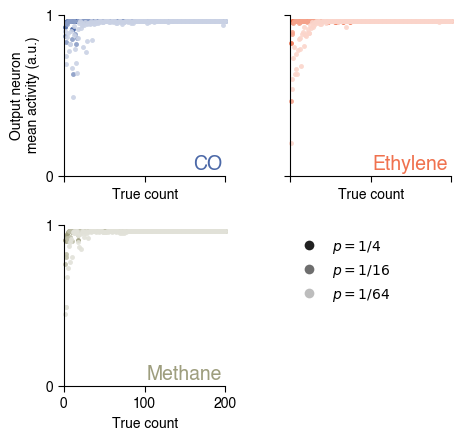

In [8]:
n_out = 1
n_hd = 10000
k = 25
p = 1./5.  # flip probability
c1 = 'white'
p_list = [1/4., 1/16., 1/64.]

rng = np.random.default_rng(42)
cm = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True, gridspec_kw={"wspace": 0.4})
axes = axes.flatten()

x_dense = data
n_dense = x_dense.shape[1]

colour = np.zeros_like(times_sec, dtype=int)
runs = []
for j in range(len(sequence_sec)):
    t0 = sequence_sec[j]
    t1 = sequence_sec[j+1] if j+1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t0) & (times_sec < t1)
    colour[mask] = int(sequence[j][1])
    idx_start = np.where((times_sec >= t0) & (np.roll(times_sec, 1) <= t0) == True)[0]
    idx_end = np.where((np.roll(times_sec, -1) > t1) & (times_sec <= t1) == True)[0]
    if idx_end.size == 0:
        idx_end = len(times_sec)
    runs.append((int(idx_start), int(idx_end), int(sequence[j][1])))

for idx_p, p in enumerate(p_list):
    W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))
    x_hd = x_dense @ W_hd.T
    ranks = np.argsort(np.argsort(-x_hd, axis=1), axis=1)
    z_hd = np.where(ranks < k, 1., 0.)
    W_out = np.zeros((n_out, n_hd))
    output = np.zeros((x_dense.shape[0]))

    for i, row in enumerate(z_hd):
        active_idx = np.flatnonzero(row)                          # indices where z_hd==1
        to_flip = active_idx[rng.random(active_idx.size) < p]     # Bernoulli(p) per active index
        W_out[0, to_flip] = 1.0

        out = row @ W_out.T
        output[i] = out

    # Count how many presentations (blocks) each gas has in the whole recording
    gas_presentations = {}

    # Initialize dict-of-lists to collect per-block stats
    block_sums = {
        "gas_id": [],
        "start_idx": [],
        "end_idx": [],          # end is exclusive
        "length": [],           # <-- NEW: block length (samples)
        "start_time": [],
        "end_time": [],
        "output_sum": [],
        "true_count": [],       # total presentations of that gas in the recording
    }

    # Fill the dict
    for s, e, gas_id in runs:
        if gas_id == 0:
            continue
        gas_presentations[gas_id] = gas_presentations.get(gas_id, 0) + 1
        block_sums["gas_id"].append(int(gas_id))
        block_sums["start_idx"].append(int(s))
        block_sums["end_idx"].append(int(e))
        block_sums["length"].append(int(e - s))
        block_sums["start_time"].append(float(times_sec[s]))
        block_sums["end_time"].append(float(times_sec[e-1] if e-1 < len(times_sec) else times_sec[-1]))
        block_sums["output_sum"].append(float(output[s:e].sum()))
        block_sums["true_count"].append(int(gas_presentations[gas_id]))

    # Extract arrays
    gid = np.asarray(block_sums["gas_id"])
    tc  = np.asarray(block_sums["true_count"])
    os_ = np.asarray(block_sums["output_sum"], dtype=float)
    L   = np.asarray(block_sums["length"], dtype=float)

    # Mean output per block = sum / length
    mean_os = os_ / np.maximum(L, 1.0)

    labels = {1: 'CO', 2: 'Ethylene', 3: 'Methane'}


    for ax, gas in zip(axes[:3], [1, 2, 3]):
        graded_cm = LinearSegmentedColormap.from_list("to_light", [cm((gas - 1)), c1])  # continuous
        colors = [graded_cm(t) for t in np.linspace(0., 0.7, len(p_list))]
        m = (gid == gas)
        c = colors[idx_p]
        ax.scatter(
            tc[m], mean_os[m],
            marker='.', s=50, lw=0.,
            color=c, alpha=0.9, clip_on=False,
        )

for ax, gas in zip(axes, [1, 2, 3]):
# Colored gas label in bottom-right corner (replaces title)
    ax.text(
        0.98, 0.02, labels.get(gas, f'Gas {gas}'),
        transform=ax.transAxes, ha='right', va='bottom',
        color=cm(gas-1), fontsize=14,
    )

    ax.set_xlim(0, 200)
    ax.set_ylim(0, ax.get_ylim()[1])
    # ax.spines['left'].set_position(('data', 0))    # x=0 vertical spine
    # ax.spines['bottom'].set_position(('data', 0))  # y=0 horizontal spine
    ax.set_xticks([0, 100, 200])
    ax.set_yticks(ax.get_ylim(), [0, 1])
    ax.set_box_aspect(1)

# shared labels
axes[0].set_ylabel('Output neuron\n mean activity (a.u.)')
for ax in axes:
    ax.set_xlabel("True count")

# --- global legend (vertical, right side) ---
graded_cm = LinearSegmentedColormap.from_list("to_light", [cm(4), c1])
legend_colors = [graded_cm(t) for t in np.linspace(0., 0.7, len(p_list))]

handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor=legend_colors[i], markeredgecolor='none', markersize=7)
    for i in range(len(p_list))
]
labels_leg = [fr"$p={{1}}/{{{int(1/p)}}}$" for p in p_list]
axes[3].set_axis_off()
axes[3].legend(
    handles, labels_leg,
    loc="center left",
    bbox_to_anchor=(0.00, 0.7),
    frameon=False,
    ncol=1,
    handletextpad=0.6,
    borderaxespad=0.0
)

# leave space on the right for the legend
# plt.tight_layout(rect=[0, 0, 0.86, 1])


# plt.tight_layout()
plt.savefig("figs/count_sketch_no_learning.png", dpi=600, bbox_inches="tight")
plt.savefig("figs/count_sketch_no_learning.pdf", dpi=600, bbox_inches="tight")
plt.show()